In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import json
import torch
import torchaudio
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForSequenceClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colormaps

from functions import AudioMNISTDataset, create_dataloaders, collate_fn

from scipy.spatial.distance import pdist, squareform

from scipy.spatial.distance import cdist

import time

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def plot_umap(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Ensure 'features' is a numpy array
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)

    if len(np.unique(labels)) == 2:
        cmap_rg = ListedColormap(["red", "green"])
        cmap = cmap_rg
    else:
        cmap = 'tab10'
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

def forward_pass(model, dataloader):
    with torch.no_grad():
        all_labels = []
        for batch in dataloader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)
    
            # Forward pass
            outputs = model(input_values)
            all_labels.append(labels.cpu())
    return all_labels

def hook(module, input, output):
    # Apply mean pooling over the sequence length dimension (dim=1)
    pooled_output = output[1].mean(dim=1)  # Shape: [batch_size, 768]
    projector_features.append(pooled_output.detach())
    
def register_hook(layer):
    """
    Registers a forward hook to store features in the dynamically provided storage.

    Args:
        layer (nn.Module): The layer to which the hook should be attached.
        feature_storage (list): A mutable list to store the features extracted by the hook.
    
    Returns:
        hook_handle (torch.utils.hooks.RemovableHandle): Handle to manage the hook lifecycle.
    """
    feature_storage = []
    def hook(module, input, output):
        
        if isinstance(output, tuple):
            if isinstance(output[0], torch.Tensor):
                output = output[0]
            elif isinstance(output[1], torch.Tensor):
                output = output[1]
            elif isinstance(output[2], torch.Tensor):
                output = output[3]
        #elif isinstance(output, tuple):
        #    print("ok")
        else:
            raise ValueError('Bad format')
        
        #elif isinstance(output, torch.Tensor):
            # do nothing - output is correct

        # Apply mean pooling over the sequence length dimension (dim=1)
        pooled_output = output.mean(dim=1)  # Shape: [batch_size, 768]
        feature_storage.append(pooled_output.detach())  # Append the pooled output to the passed storage

    # Register the hook
    hook_handle = layer.register_forward_hook(hook)
    return hook_handle, feature_storage

In [3]:
def forward_pass2(model, dataloader, metadata):
    """
    Perform a forward pass and collect metadata along with labels.
    
    Args:
        model: The model to run the forward pass on.
        dataloader: A PyTorch DataLoader for the dataset.
        metadata: Metadata dictionary loaded from audioMNIST_meta.json.
    
    Returns:
        result: A list of dictionaries, each containing label, file path, and metadata.
    """
    result = []
    with torch.no_grad():
        for batch in dataloader:
            input_values, labels, file_paths = batch  # File paths are now returned by the DataLoader
            input_values = input_values.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_values)

            # Process metadata for each file
            for label, file_path in zip(labels.cpu().numpy(), file_paths):
                # Extract speaker ID from the file path
                speaker_id = os.path.basename(os.path.dirname(file_path))
                speaker_metadata = metadata.get(speaker_id, {})
                
                # Append metadata, label, and file info
                result.append({
                    "label": int(label),
                    "file_path": file_path,
                    "metadata": speaker_metadata
                })
    return result

In [4]:
# Load the metadata
with open("audioMNIST_meta.json", "r") as f:
    metadata = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

dataloaders = create_dataloaders("AudioMNIST/data/", processor, batch_size=16)

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

In [5]:
# Load saved model
model1 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model1.load_state_dict(torch.load("seq-class-head.pth", weights_only=True))
model1.to(device)
model1.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


### UMAP of model1 (only class head)

In [6]:
#projector_hook, projector_features = register_hook(model1.projector)
#feat_hook, feature_projection_features = register_hook(model1.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model1.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model1.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model1.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model1.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model1.wav2vec2.encoder.layers[4].attention)
hook6, hook6_s = register_hook(model1.wav2vec2.encoder.layers[5].attention)
hook7, hook7_s = register_hook(model1.wav2vec2.encoder.layers[6].attention)
hook8, hook8_s = register_hook(model1.wav2vec2.encoder.layers[7].attention)
hook9, hook9_s = register_hook(model1.wav2vec2.encoder.layers[8].attention)
hook10, hook10_s = register_hook(model1.wav2vec2.encoder.layers[9].attention)
hook11, hook11_s = register_hook(model1.wav2vec2.encoder.layers[10].attention)
hook12, hook12_s = register_hook(model1.wav2vec2.encoder.layers[11].attention)

data_dict = forward_pass2(model1, test_loader, metadata)

# Remove the hook after extraction
#projector_hook.remove()
#feat_hook.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()
hook7.remove()
hook8.remove()
hook9.remove()
hook10.remove()
hook11.remove()
hook12.remove()

# Stack the collected features and labels
#projector_features = torch.cat(projector_features, dim=0)
#feat_hook_features = torch.cat(feature_projection_features, dim=0)
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
hook6_s = torch.cat(hook6_s, dim=0)
hook7_s = torch.cat(hook7_s, dim=0)
hook8_s = torch.cat(hook8_s, dim=0)
hook9_s = torch.cat(hook9_s, dim=0)
hook10_s = torch.cat(hook10_s, dim=0)
hook11_s = torch.cat(hook11_s, dim=0)
hook12_s = torch.cat(hook12_s, dim=0)

labels = [entry['label'] for entry in data_dict]
labels_np = np.array(labels)
metadata_dict = [entry['metadata'] for entry in data_dict]

# Convert to NumPy for UMAP
#projector_features_np = projector_features.cpu().numpy()
#feat_hook_features_np = feat_hook_features.cpu().numpy()
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
hook6_n = hook6_s.cpu().numpy()
hook7_n = hook7_s.cpu().numpy()
hook8_n = hook8_s.cpu().numpy()
hook9_n = hook9_s.cpu().numpy()
hook10_n = hook10_s.cpu().numpy()
hook11_n = hook11_s.cpu().numpy()
hook12_n = hook12_s.cpu().numpy()

In [9]:
metadata_dict[0]

# speaker_ID

{'accent': 'German',
 'age': '27',
 'gender': 'male',
 'native speaker': 'no',
 'origin': 'Europe, Germany, Freiberg',
 'recordingdate': '17-07-19-17-47-06',
 'recordingroom': 'Kino'}

In [10]:
accents = [entry['accent'] for entry in metadata_dict]
ages = [entry['age'] for entry in metadata_dict]
genders = [entry['gender'] for entry in metadata_dict]
native = [entry['native speaker'] for entry in metadata_dict]
origins = [entry['origin'] for entry in metadata_dict]

genders_np = np.array(genders)

gender_bin = np.zeros(len(genders_np))
for i, gen in enumerate(genders_np):
    if gen == 'male':
        gender_bin[i] = 0
    else:
        gender_bin[i] = 1

native_np = np.array(native)

native_bin = np.zeros(len(native_np))
for i, gen in enumerate(native_np):
    if gen == 'no':
        native_bin[i] = 0
    else:
        native_bin[i] = 1

In [ ]:
hookn = [hook1_n, hook2_n, hook3_n, hook4_n, hook5_n, hook6_n, hook7_n, hook8_n, hook9_n, hook10_n, hook11_n, hook12_n]

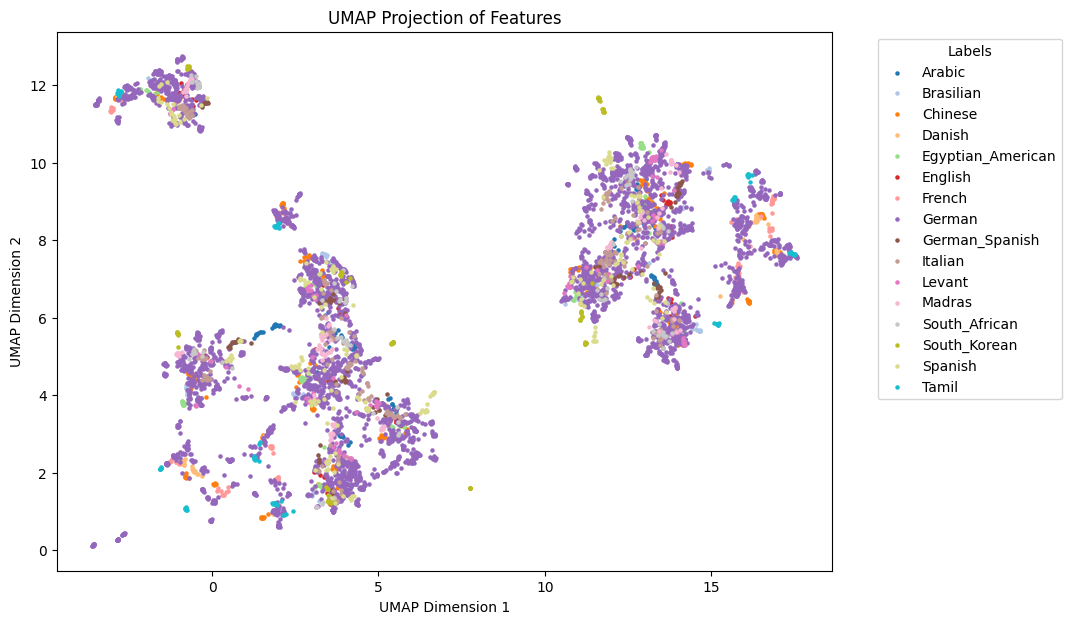

In [19]:
def normalize_labels(labels):
    """
    Normalize labels by grouping similar ones.
    """
    label_mapping = {
        'Arabic': 'Arabic',
        'Brasilian': 'Brasilian',
        'Chinese': 'Chinese',
        'Danish': 'Danish',
        'Egyptian_American?': 'Egyptian_American',
        'English': 'English',
        'French': 'French',
        'German': 'German',
        'German/Spanish': 'German_Spanish',
        'Italian': 'Italian',
        'Levant': 'Levant',
        'Madras': 'Madras',
        'South African': 'South_African',
        'South Korean': 'South_Korean',
        'Spanish': 'Spanish',
        'Tamil': 'Tamil',
        'german': 'German',  # Group with 'German'
    }
    return np.array([label_mapping[label] for label in labels])

def create_color_mapping(unique_labels):
    """
    Assign colors to unique labels using a specified colormap.
    """
    num_labels = len(unique_labels)
    cmap = colormaps['tab20']  # Access the 'tab10' colormap
    colors = [cmap(i / num_labels) for i in range(num_labels)]  # Normalize indices to [0, 1]
    return {label: colors[i] for i, label in enumerate(unique_labels)}

def plot_umap_with_labels(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Normalize labels
    normalized_labels = normalize_labels(labels)

    # Create unique label-color mapping
    unique_labels = np.unique(normalized_labels)
    color_mapping = create_color_mapping(unique_labels)

    # Map labels to colors
    label_colors = np.array([color_mapping[label] for label in normalized_labels])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for label, color in color_mapping.items():
        mask = normalized_labels == label
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=label, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

plot_umap_with_labels(hook2_n, accents)

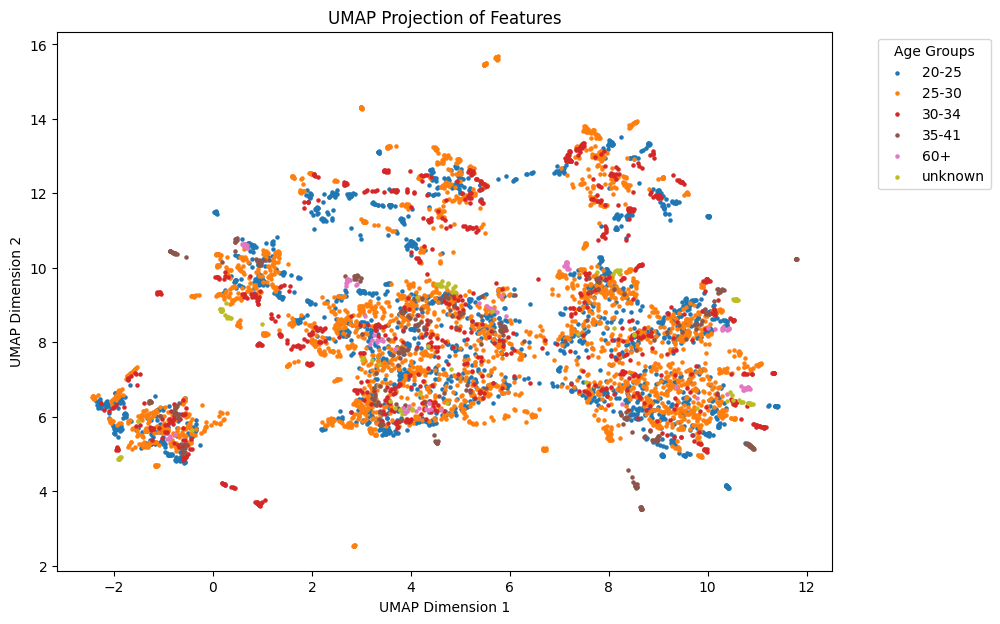

In [24]:
def group_ages(ages):
    """
    Normalize labels by grouping similar ones.
    """
    age_mapping = {
        '1234': 'unknown',
        '22': '20-25',
        '23': '20-25',
        '24': '20-25',
        '25': '20-25',
        '26': '25-30',
        '27': '25-30',
        '28': '25-30',
        '29': '25-30',
        '30': '25-30',
        '31': '30-34',
        '32': '30-34',
        '33': '30-34',
        '34': '30-34',
        '35': '35-41',
        '36': '35-41',
        '41': '35-41',
        '61': '60+'
    }
    return np.array([age_mapping[str(age)] for age in ages])
    
def create_color_mapping(unique_labels):
    """
    Assign colors to unique labels using a specified colormap.
    """
    num_labels = len(unique_labels)
    cmap = colormaps['tab10']  # Access the 'tab10' colormap
    colors = [cmap(i / num_labels) for i in range(num_labels)]  # Normalize indices to [0, 1]
    return {label: colors[i] for i, label in enumerate(unique_labels)}

def plot_umap_with_grouped_ages(features, ages, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Normalize ages
    grouped_ages = group_ages(ages)

    # Create unique label-color mapping
    unique_labels = np.unique(grouped_ages)
    color_mapping = create_color_mapping(unique_labels)

    # Map grouped ages to colors
    label_colors = np.array([color_mapping[label] for label in grouped_ages])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for label, color in color_mapping.items():
        mask = grouped_ages == label
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=label, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Age Groups")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

plot_umap_with_grouped_ages(hook1_n, ages)

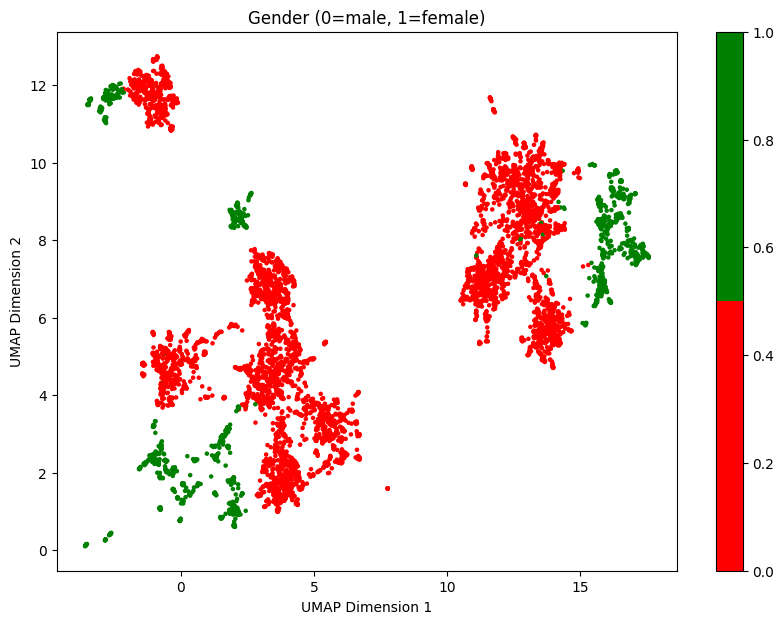

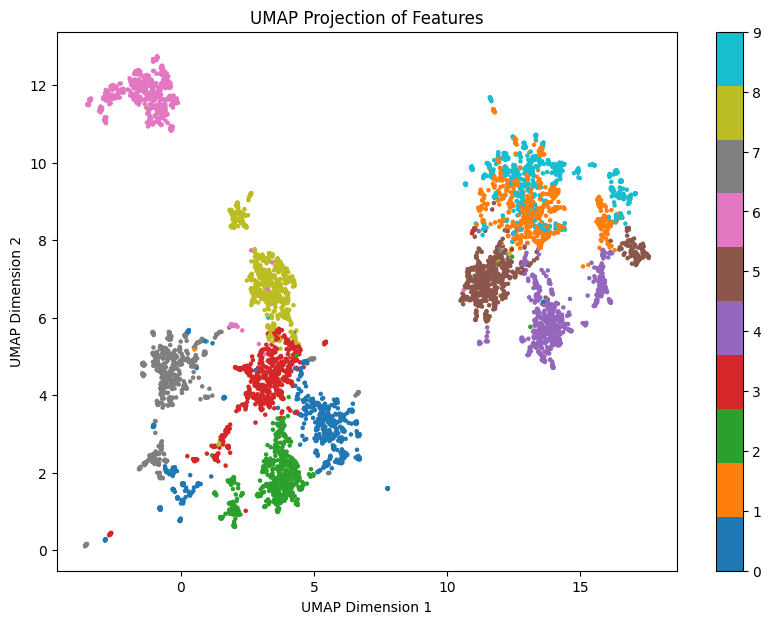

In [29]:
plot_umap(hook2_n, gender_bin, title = "Gender (0=male, 1=female)")
plot_umap(hook2_n, labels_np)

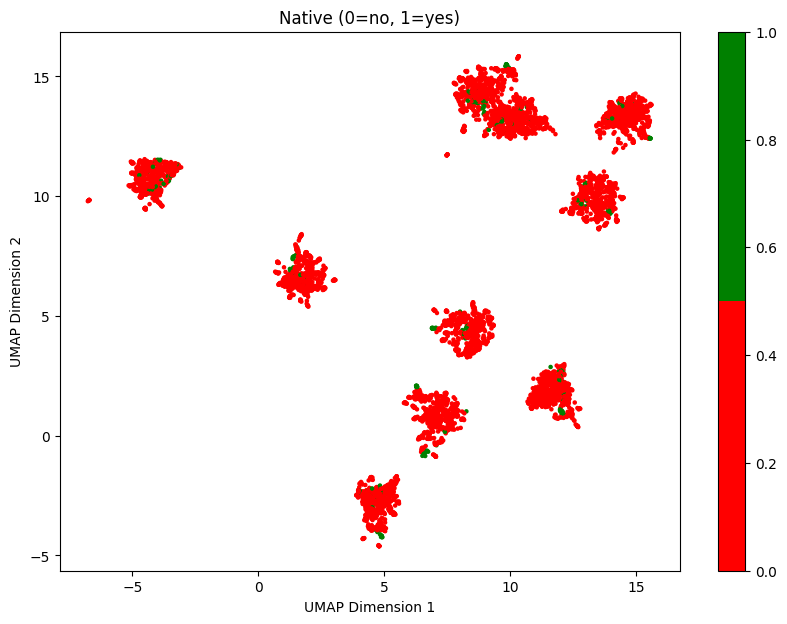

In [28]:
plot_umap(hook5_n, native_bin, title="Native (0=no, 1=yes)")

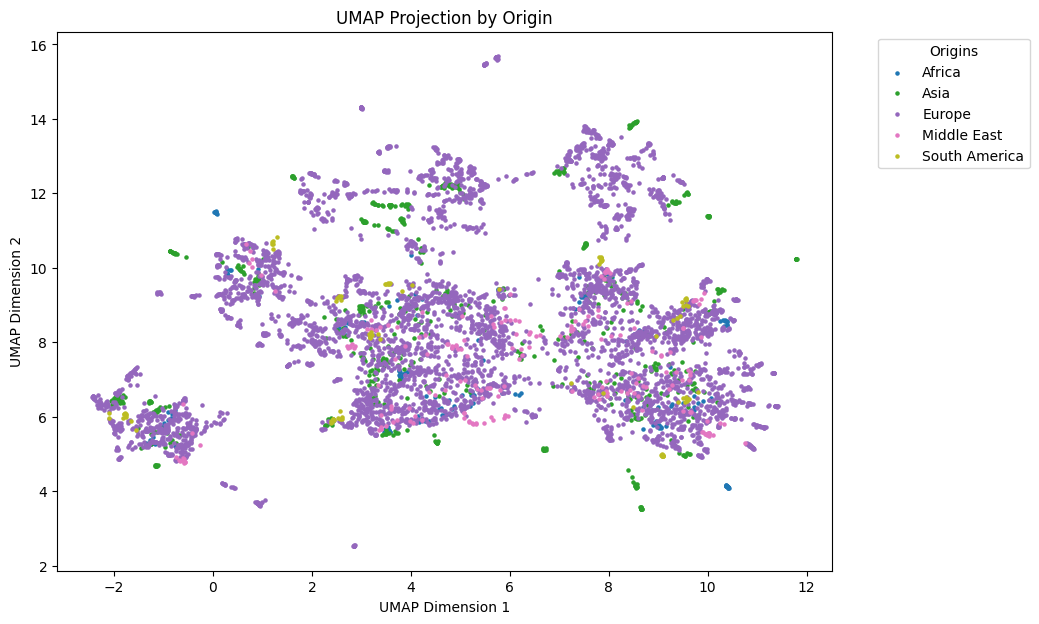

In [21]:
def normalize_origins(origins):
    """
    Normalize detailed origins into broader categories (e.g., continents or countries).
    """
    origin_mapping = {
        "Africa": "Africa",
        "Egypt": "Africa",
        "South Africa": "Africa",
        "Asia": "Asia",
        "China": "Asia",
        "India": "Asia",
        "South Korea": "Asia",
        "Europe": "Europe",
        "Denmark": "Europe",
        "France": "Europe",
        "Spanien": "Europe",
        "Germany": "Europe",
        "Italy": "Europe",
        "Poland": "Europe",
        "Spain": "Europe",
        "Syria": "Middle East",
        "Brazil": "South America"
    }
    # Map each origin to its normalized category
    return np.array([origin_mapping[origin.split(", ")[1]] for origin in origins])
    
def create_origin_color_mapping(unique_origins):
    """
    Assign unique colors to normalized origin categories.
    """
    num_origins = len(unique_origins)
    cmap = colormaps['tab20']  # Use 'tab20' for diverse colors
    colors = [cmap(i / num_origins) for i in range(num_origins)]
    return {origin: colors[i] for i, origin in enumerate(unique_origins)}

def plot_umap_with_origins(features, origins, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection by Origin"):
    """
    Plot UMAP embeddings colored by normalized origin categories.
    """
    # Normalize origins
    grouped_origins = normalize_origins(origins)

    # Create unique label-color mapping
    unique_origins = np.unique(grouped_origins)
    color_mapping = create_origin_color_mapping(unique_origins)

    # Map grouped origins to colors
    origin_colors = np.array([color_mapping[origin] for origin in grouped_origins])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for origin, color in color_mapping.items():
        mask = grouped_origins == origin
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=origin, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Origins")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()
    
plot_umap_with_origins(hook1_n, origins)

In [35]:
# Time to calculate dist matrix
start_time = time.time()
distances = squareform(pdist(hook5_n, metric='euclidean'))
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.59205436706543 seconds ---


--- 9.83971381187439 seconds ---


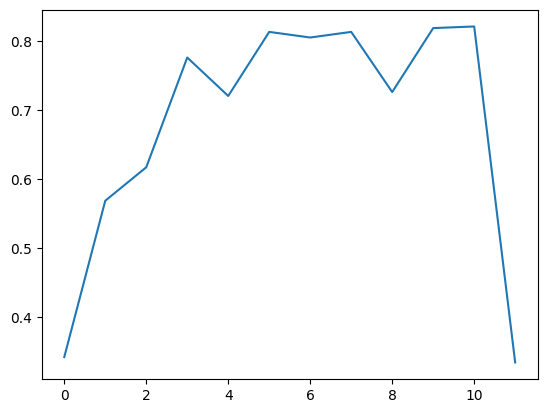

In [18]:
s_time = time.time()
scores = []
for h in hookn:
    metric = nn_metric(h, labels_np, t=0.6)
    scores.append(metric)

print("--- %s seconds ---" % (time.time() - s_time))

plt.plot(scores)
plt.show()

--- 0.17391037940979004 seconds ---


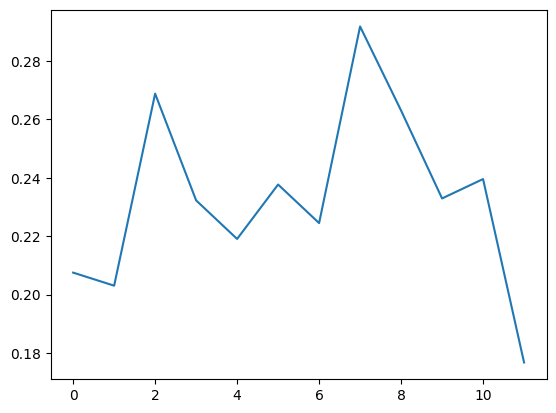

In [20]:
s_time = time.time()
scores = []
for h in hookn:
    temp_mean, dp = discriminant_power(h, labels_np)
    scores.append(temp_mean)
print("--- %s seconds ---" % (time.time() - s_time))
plt.plot(scores)
plt.show()

--- 13.790061950683594 seconds ---


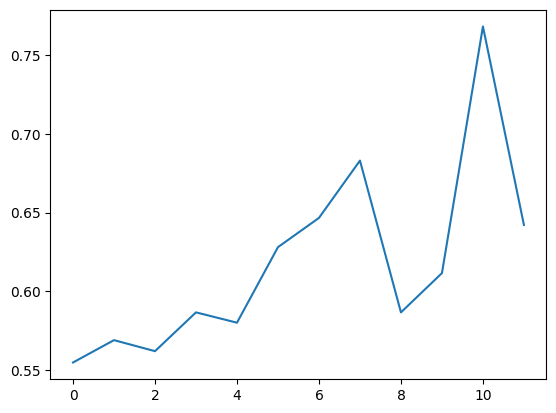

In [29]:
s_time = time.time()
scores = []
for h in hookn:
    temp = normalized_clustering_score(h, labels_np)
    scores.append(temp)
print("--- %s seconds ---" % (time.time() - s_time))
plt.plot(scores)
plt.show()

--- 9.864478588104248 seconds ---


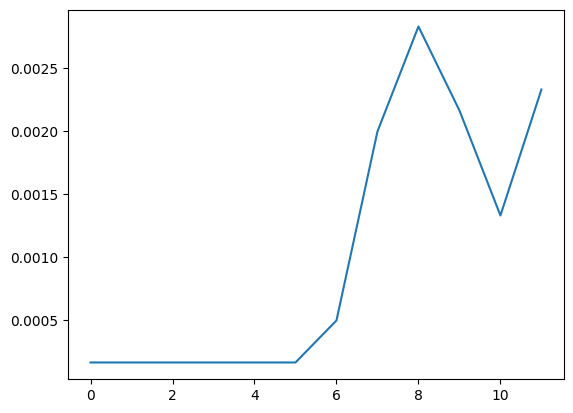

In [41]:
s_time = time.time()
scores = []
for h in hookn:
    temp = lda_mm(h, labels_np)
    scores.append(temp)
print("--- %s seconds ---" % (time.time() - s_time))
plt.plot(scores)
plt.show()

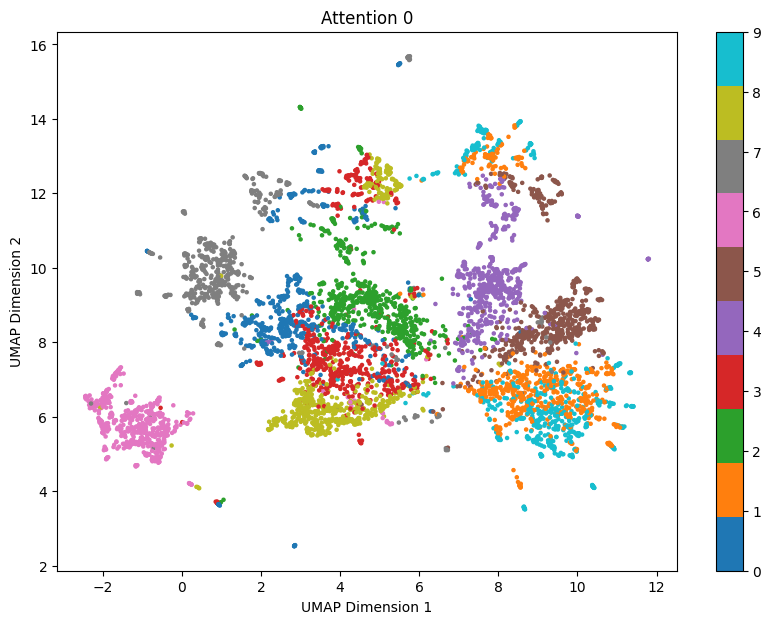

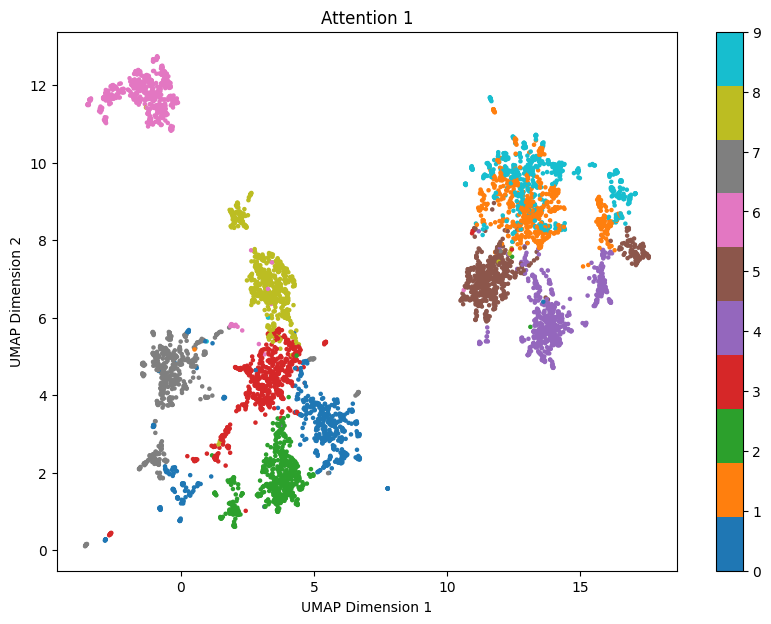

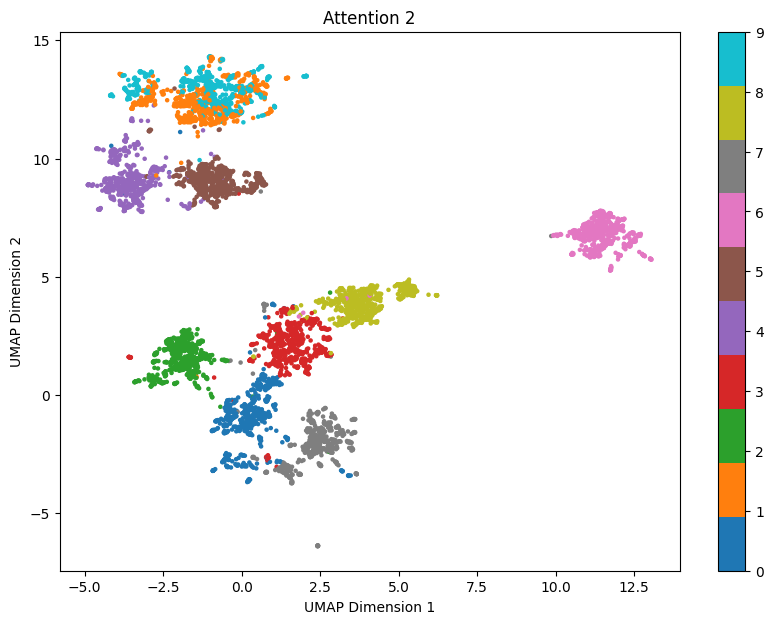

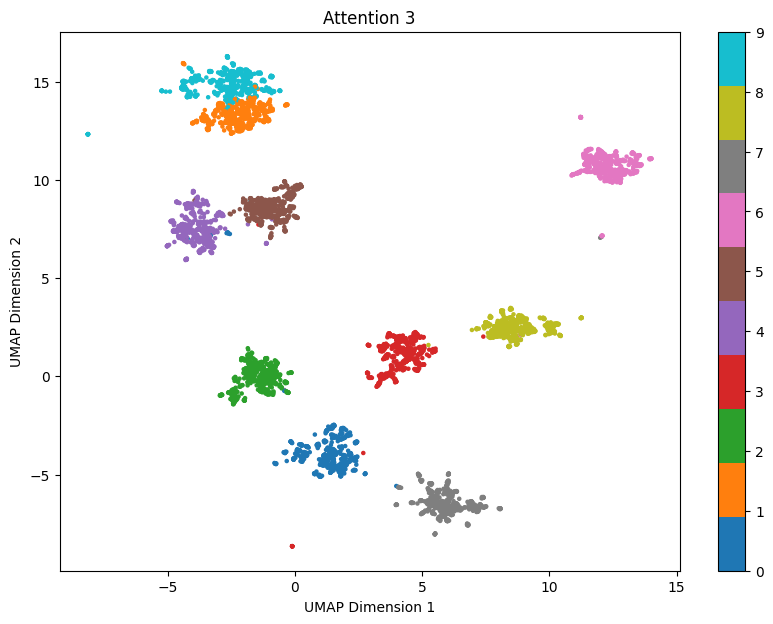

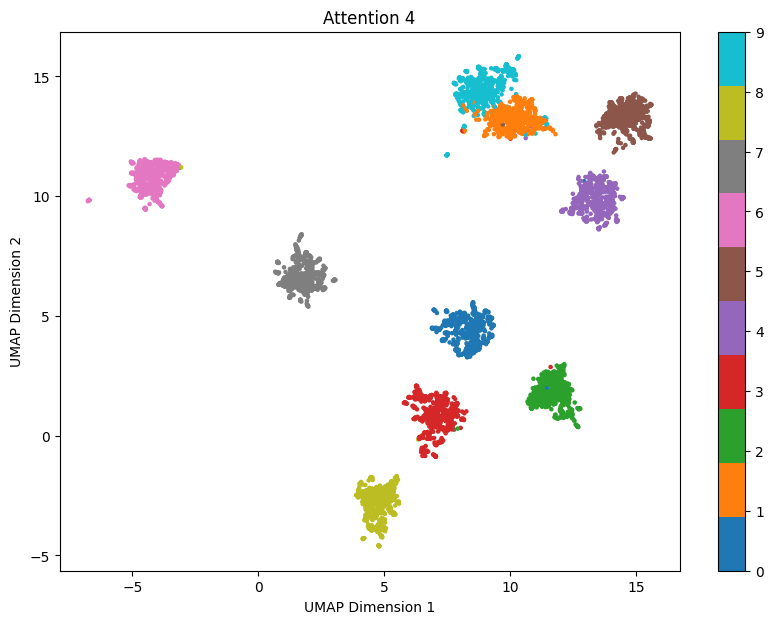

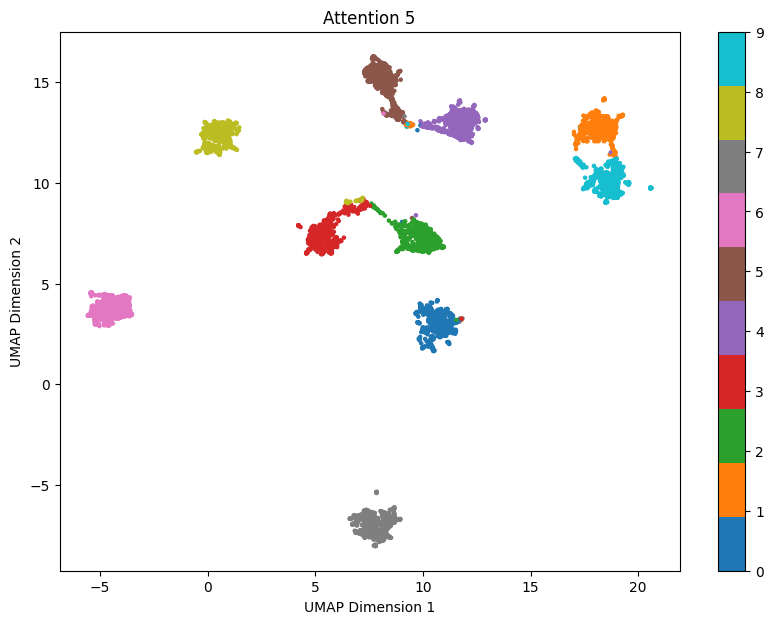

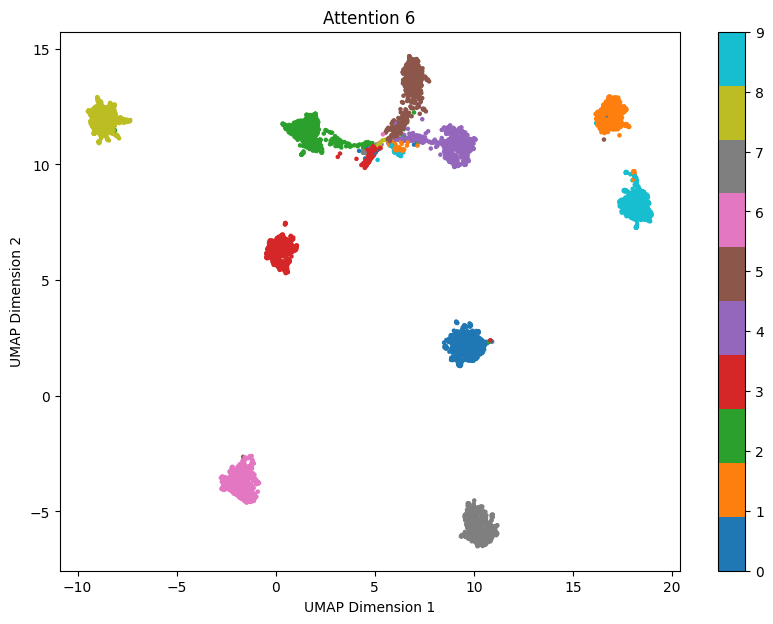

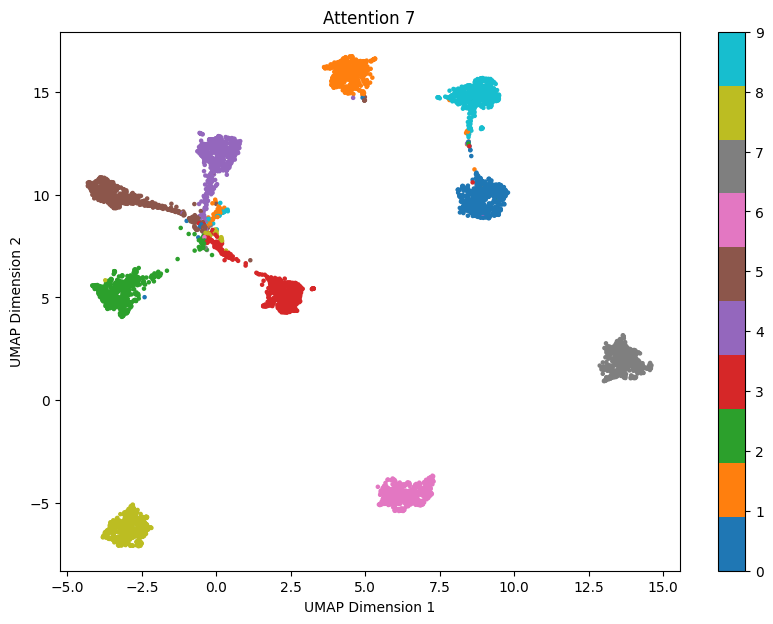

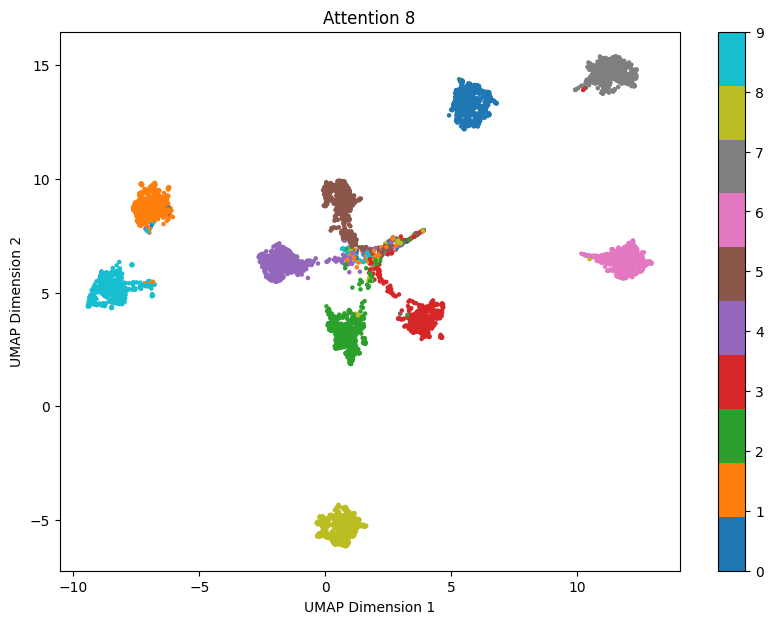

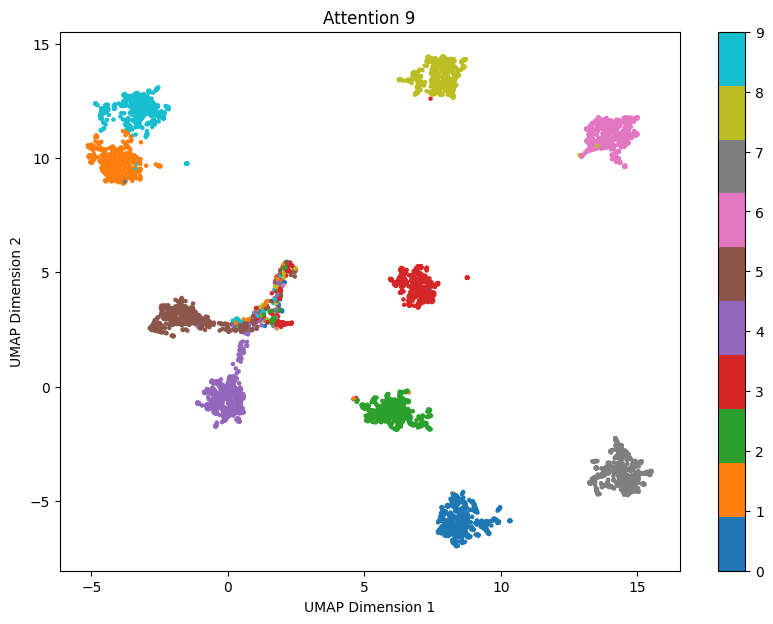

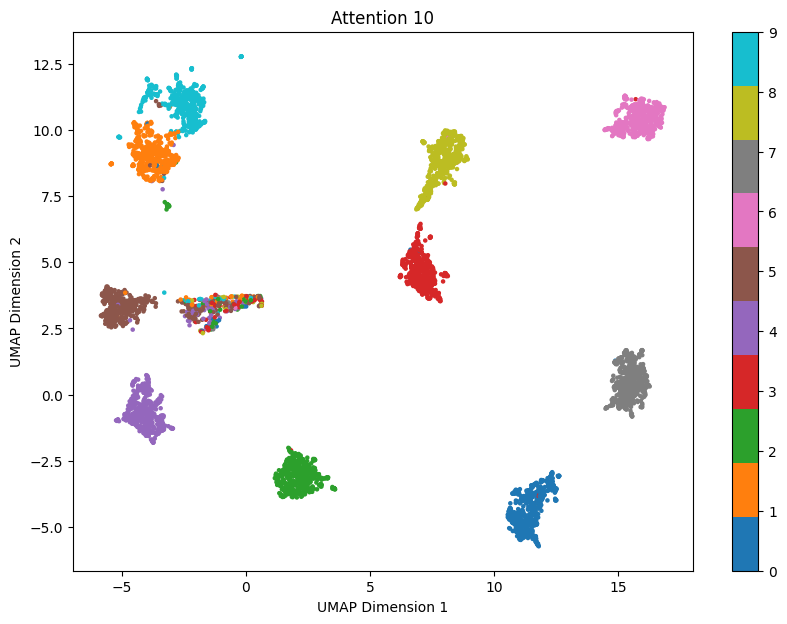

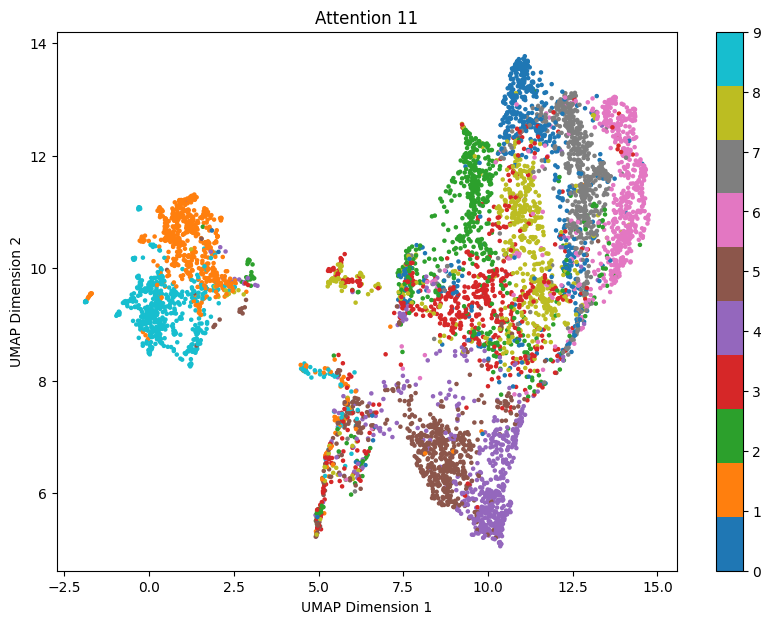

In [13]:
i = 0
for h in hookn:
    plot_umap(h, labels_np, title=f"Attention {i}")
    i+=1

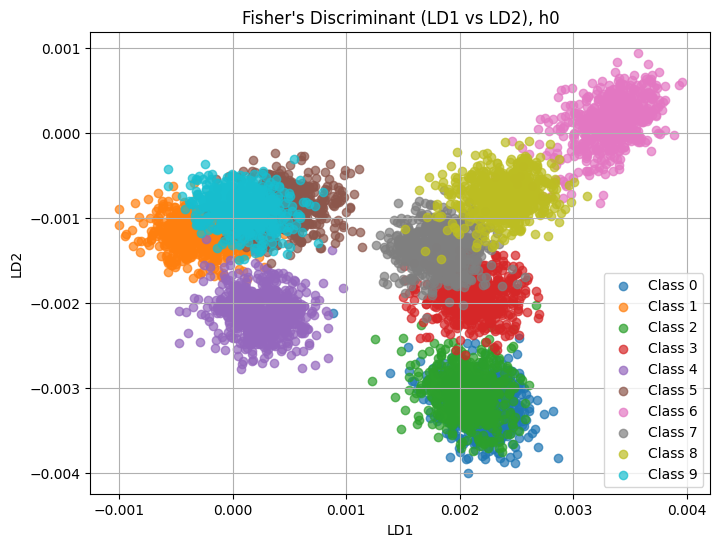

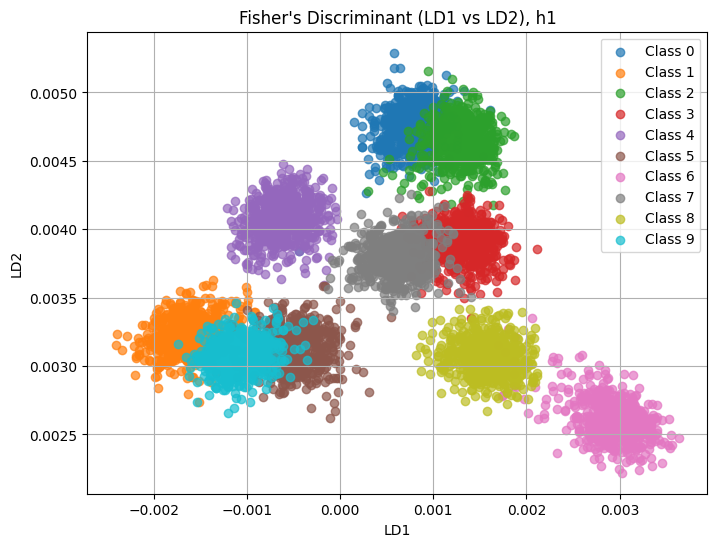

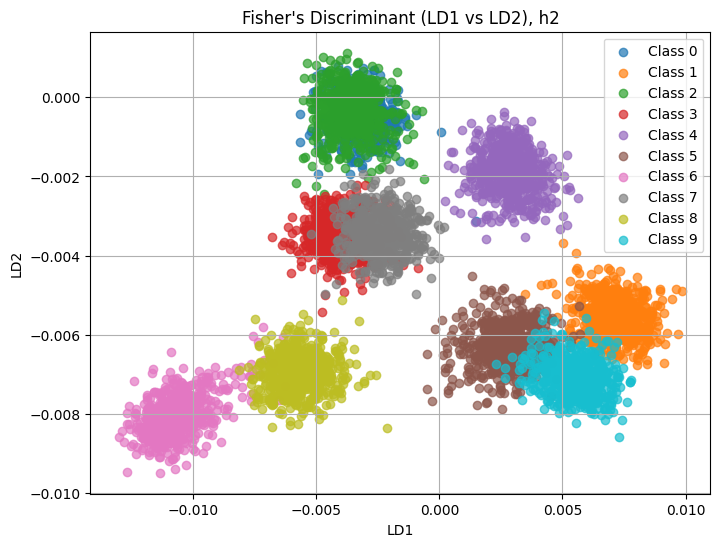

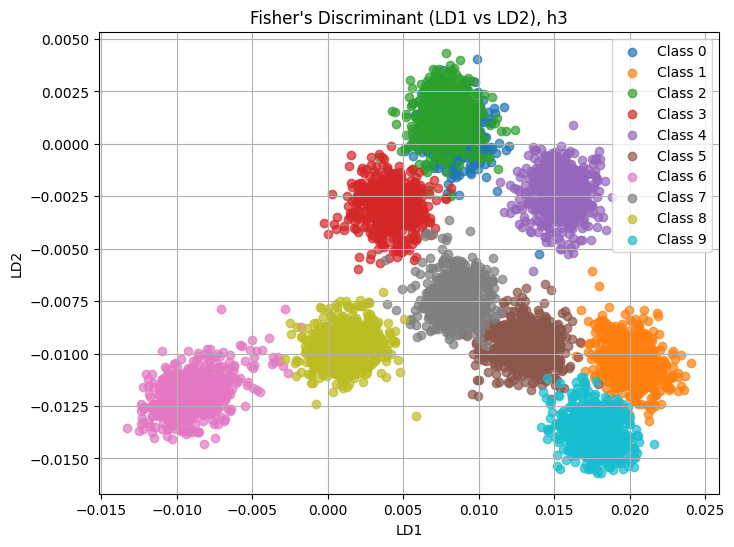

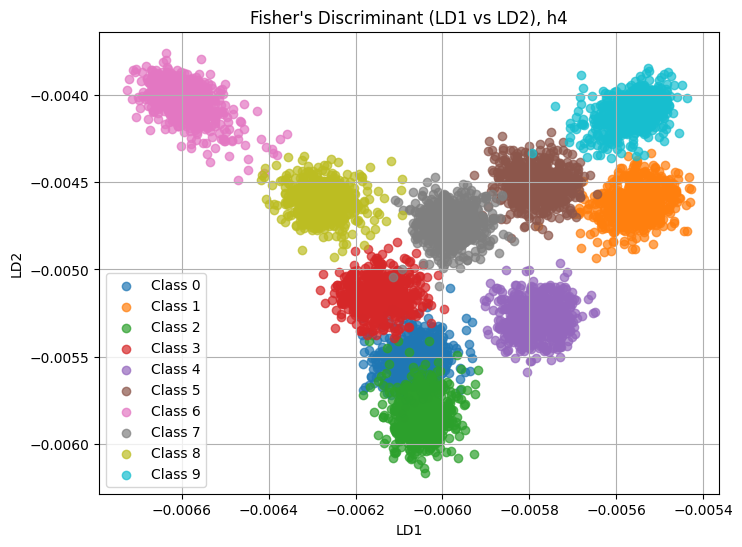

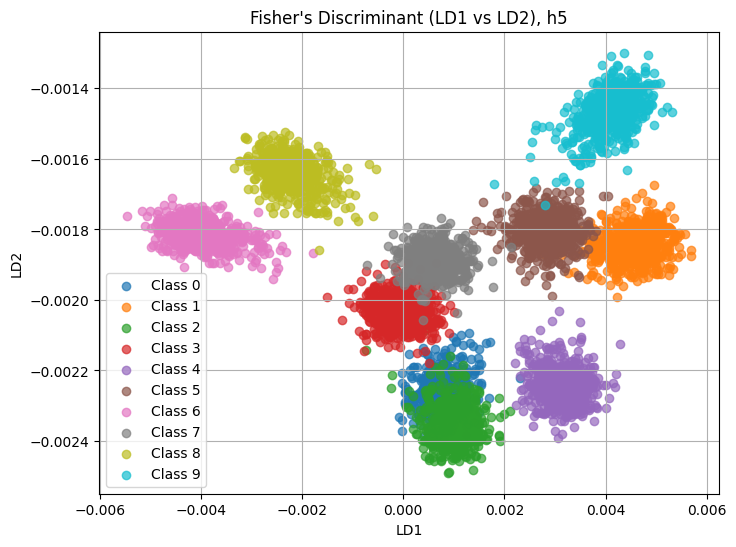

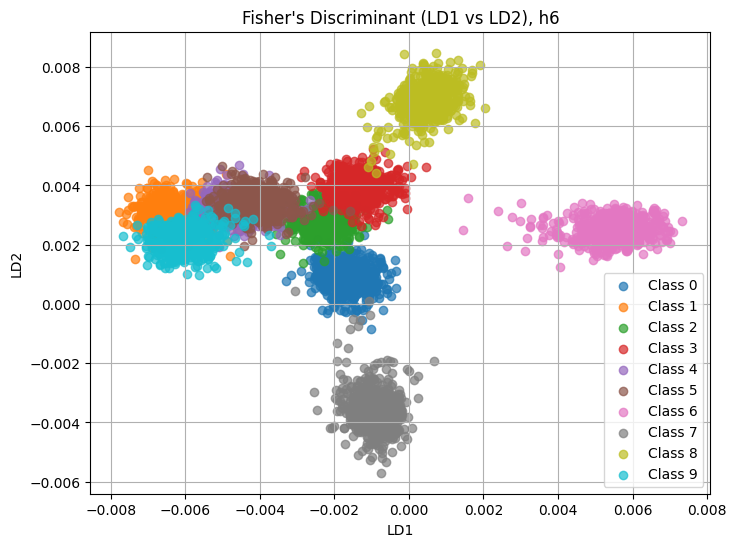

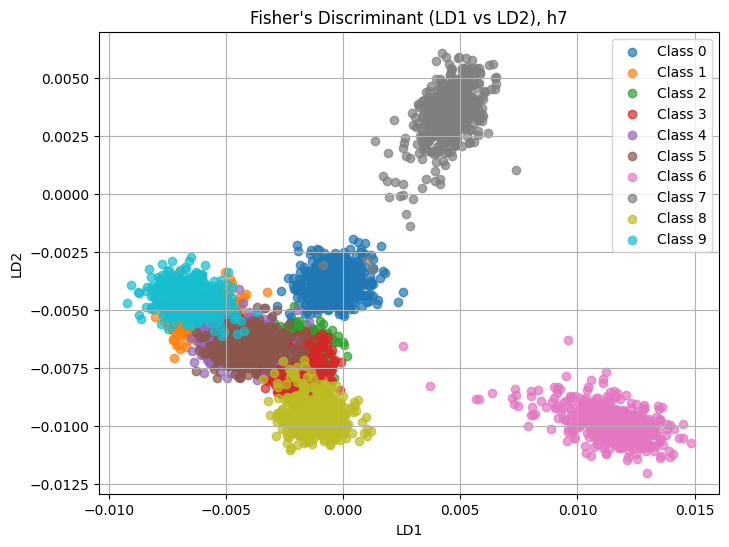

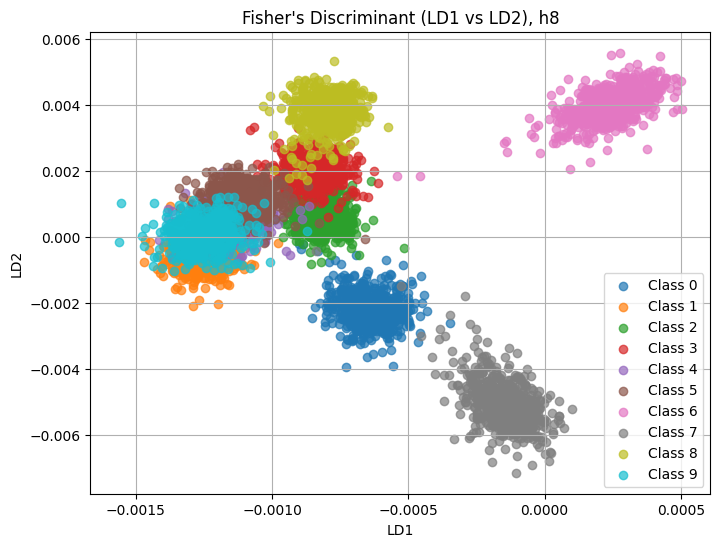

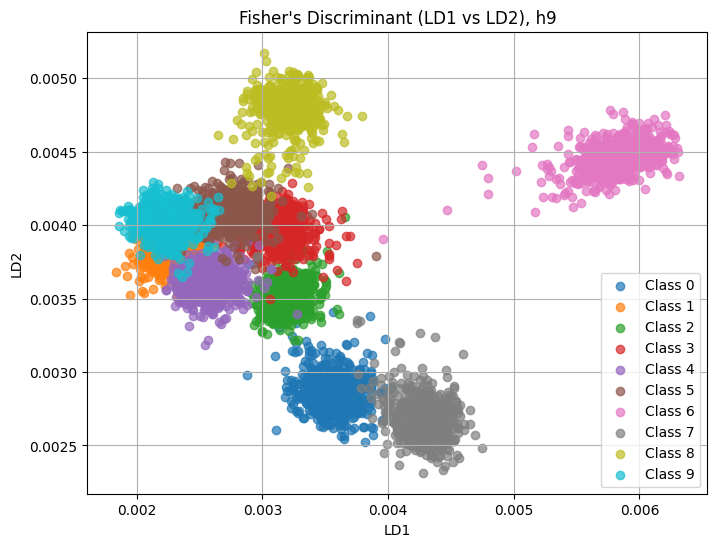

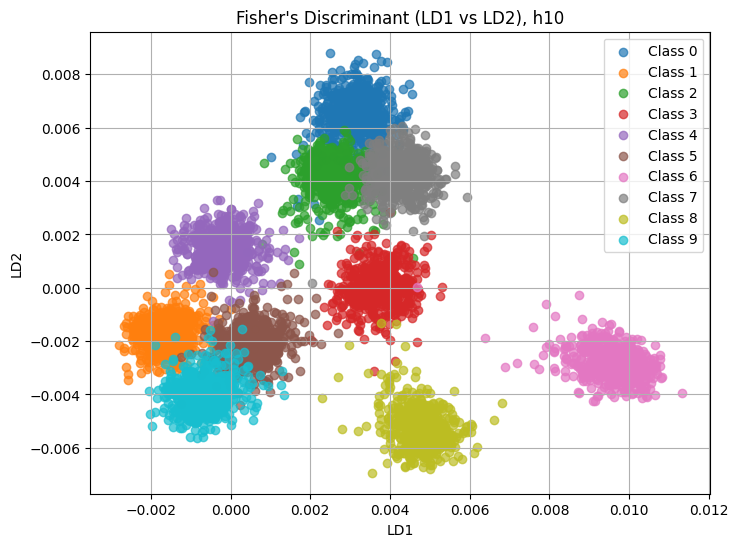

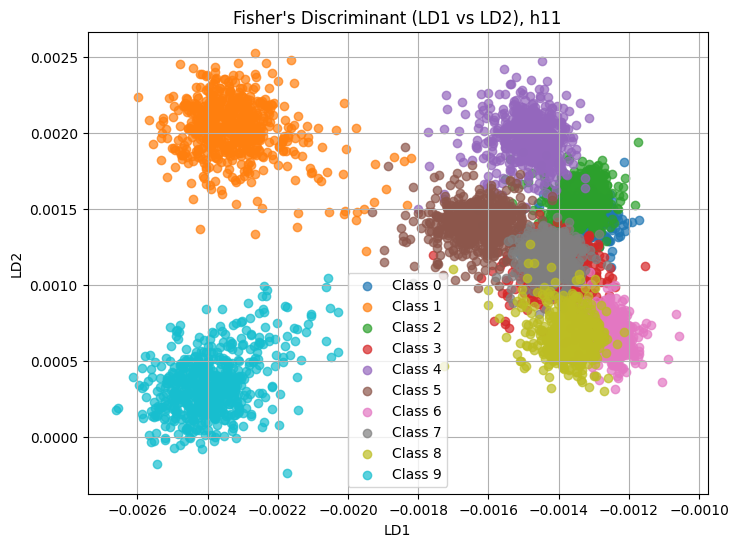

In [44]:
def fisher_linear_discriminant(data, classes):
    """
    Fisher's Linear Discriminant for k classes.
    
    Args:
        data (np.ndarray): Shape (6000, 768), feature vectors.
        classes (np.ndarray): Shape (6000,), class labels (0, 1, ..., k-1).
    
    Returns:
        np.ndarray: Projection matrix of shape (768, k-1).
    """
    # Unique classes and overall mean
    class_labels = np.unique(classes)
    k = len(class_labels)  # Number of classes
    n_features = data.shape[1]  # Feature dimensionality
    overall_mean = np.mean(data, axis=0)

    # Compute within-class scatter matrix S_W and between-class scatter matrix S_B
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))
    
    for label in class_labels:
        class_data = data[classes == label]
        class_mean = np.mean(class_data, axis=0)
        
        # Within-class scatter
        S_W += np.cov(class_data, rowvar=False) * (class_data.shape[0] - 1)
        
        # Between-class scatter
        n_c = class_data.shape[0]  # Number of samples in the class
        mean_diff = (class_mean - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff @ mean_diff.T)

    # Solve the generalized eigenvalue problem for S_W^-1 S_B
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(-eigvals.real)  # Descending order
    eigvecs = eigvecs[:, sorted_indices]
    
    # Select top k-1 eigenvectors
    W = eigvecs[:, :k-1].real  # Projection matrix of shape (768, k-1)
    return W
    
def plot_pairwise_2d(data, classes, W, dim1=0, dim2=1, h=''):
    """
    Pairwise 2D plot for projected data.
    
    Args:
        data (np.ndarray): Original data of shape (6000, 768).
        classes (np.ndarray): Class labels of shape (6000,).
        W (np.ndarray): Projection matrix of shape (768, k-1).
        dim1 (int): Index of the first dimension to plot.
        dim2 (int): Index of the second dimension to plot.
    """
    # Project data
    projected_data = data @ W  # Shape (6000, 9 for 10 classes)
    
    plt.figure(figsize=(8, 6))
    for label in np.unique(classes):
        plt.scatter(projected_data[classes == label, dim1],
                    projected_data[classes == label, dim2],
                    label=f'Class {label}', alpha=0.7)
    plt.title(f'Fisher\'s Discriminant (LD{dim1 + 1} vs LD{dim2 + 1}), h{h}')
    plt.xlabel(f'LD{dim1 + 1}')
    plt.ylabel(f'LD{dim2 + 1}')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
i = 0
for h in hookn:
    W = fisher_linear_discriminant(h, labels_np)
    plot_pairwise_2d(h, labels_np, W, dim1=0, dim2=1, h=i)
    i+=1

In [28]:
def normalized_clustering_score(data, labels):
    """
    Compute a normalized clustering score adjusted for feature dimensionality.
    
    Parameters:
        labels (array-like): 1D array of cluster labels for each data point.
        data (ndarray): 2D array of shape (n_samples, n_features).
        
    Returns:
        float: Normalized clustering quality score.
    """
    # Ensure data is in (n_samples, n_features) format
    data = np.array(data)
    labels = np.array(labels)
    
    # Validate shapes
    if data.shape[0] != len(labels):
        raise ValueError(f"Mismatch: data has {data.shape[0]} samples, but labels have {len(labels)} elements.")
    
    # Get dimensions
    n_samples, n_features = data.shape
    normalization_factor = np.sqrt(n_features)
    
    # Get unique clusters
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        raise ValueError("Clustering score requires at least two clusters.")
    
    # Compute intra-cluster compactness
    intra_distances = []
    centroids = []
    
    for label in unique_labels:
        cluster_points = data[labels == label]  # Correct indexing
        if len(cluster_points) < 2:
            continue
        # Mean intra-cluster distance
        pairwise_distances = cdist(cluster_points, cluster_points, metric='euclidean')
        mean_intra_distance = np.sum(pairwise_distances) / (len(cluster_points) * (len(cluster_points) - 1))
        intra_distances.append(mean_intra_distance)
        centroids.append(cluster_points.mean(axis=0))
    
    # Compute inter-cluster separation
    centroids = np.array(centroids)
    inter_distances = cdist(centroids, centroids, metric='euclidean')
    mean_inter_distance = np.mean(inter_distances[np.triu_indices_from(inter_distances, k=1)])
    
    # Normalize distances by sqrt of number of features
    mean_intra_distance = np.mean(intra_distances) / normalization_factor
    mean_inter_distance = mean_inter_distance / normalization_factor
    
    # Compute final score
    score = mean_inter_distance / mean_intra_distance
    return score

0.5801884627068716

In [19]:
def discriminant_power(features, labels):
    """
    Computes the normalized Discriminant Power (DP) for clustering evaluation.
    
    Parameters:
    - labels (array-like): Cluster labels for each data point (shape: [n_samples]).
    - features (ndarray): Feature matrix (shape: [n_samples, n_features]).
    
    Returns:
    - float: The overall normalized Discriminant Power (scaled between 0 and 1).
    - ndarray: Normalized Discriminant Power for each feature (shape: [n_features], scaled between 0 and 1).
    """
    # Ensure labels and features have compatible dimensions
    n_samples, n_features = features.shape
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        raise ValueError("Discriminant Power requires at least two clusters.")
    
    # Compute the global mean for each feature
    global_mean = np.mean(features, axis=0)  # Shape: [n_features]
    
    # Initialize between-cluster and within-cluster variance
    between_variance = np.zeros(n_features)  # Shape: [n_features]
    within_variance = np.zeros(n_features)  # Shape: [n_features]
    
    # Compute variances for each cluster
    for label in unique_labels:
        cluster_data = features[labels == label]
        cluster_mean = np.mean(cluster_data, axis=0)  # Mean of the cluster
        cluster_size = cluster_data.shape[0]  # Number of points in the cluster
        
        # Between-cluster variance
        between_variance += cluster_size * (cluster_mean - global_mean) ** 2
        
        # Within-cluster variance
        within_variance += np.sum((cluster_data - cluster_mean) ** 2, axis=0)
    
    # Normalize by degrees of freedom
    between_variance /= (n_clusters - 1)
    within_variance /= (n_samples - n_clusters)
    
    # Compute Discriminant Power (avoid division by zero)
    dp = between_variance / (within_variance + 1e-10)
    
    # Normalize DP values to the range [0, 1]
    min_dp = np.min(dp)
    max_dp = np.max(dp)
    normalized_dp = (dp - min_dp) / (max_dp - min_dp + 1e-10)
    
    # Return overall normalized DP (mean across features) and per-feature normalized DP
    return np.mean(normalized_dp), normalized_dp

In [14]:
from sklearn.neighbors import NearestNeighbors

def nn_metric(data, labels, t=0.2, pct = 0.1):
    min_nn = int(len(data) * pct)

    nbrs = NearestNeighbors(n_neighbors=min_nn + 1).fit(data)
    _, indices = nbrs.kneighbors(data)

    mm_c = np.array([
        np.sum(labels[neighbors[1:]] != labels[i]) for i, neighbors in enumerate(indices)
    ])

    point_mm = mm_c / min_nn
    score_arr = (point_mm <= t).astype(int)
    metric = np.sum(score_arr) / len(data)
    return metric

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def lda_mm(data, labels):
    lda = LinearDiscriminantAnalysis()
    X_lda = lda.fit_transform(data, labels)

    class_labels = np.unique(labels)
    class_centroids = np.array([X_lda[labels==label].mean(axis=0) for label in class_labels])

    mis_count = 0

    for i, point in enumerate(X_lda):
        own_c_centroid = class_centroids[labels[i]]
        other_centroids = class_centroids[class_labels != labels[i]]

        dist_to_own = np.linalg.norm(point - own_c_centroid)
        dist_to_others = np.min([np.linalg.norm(point - centroid) for centroid in other_centroids])

        if dist_to_own > dist_to_others:
            mis_count += 1

    metric = mis_count / len(data)
    return metric

## Explanations and problems:
normalized_clustering_score
computes inter and intra distances and returns metric
- Slow (needs dist matrix)
- Results dont entirely make sense

Discriminant power
Uses variances to compute within and between variance
- Uses means
- Scoring does not seem logical

Nearest Neighbor
Computes nearest neighbors to find the amount of nearest neighbors that match the class of the points.
- Requires thresholds for amount of nearest neighbors
- Requires thresholds for when to be counted as correctly classified
- Results make sense (with good thresholds)

LDA
Transforms to lda and then matches points to label centroids
- Can be problem if the shape of clusters are non-circular (although perhaps unlikely w LDA trans?
- Scoring does not quite make sense
- LDA seems to be too good at separating clusters, making bad clusterings look good


### UMAP of model2 (fine-tuned)

In [ ]:
# Load saved model
model2 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model2.load_state_dict(torch.load("seq-class-fine.pth", weights_only=True))
model2.to(device)
model2.eval()

In [ ]:
#ph2, pf2 = register_hook(model2.projector)
#fh2, fpf2 = register_hook(model2.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model2.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model2.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model2.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model2.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model2.wav2vec2.encoder.layers[4].attention)

all_labels = forward_pass(model2, test_loader)

# Remove the hook after extraction
#ph2.remove()
#fh2.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()

# Stack the collected features and labels
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to NumPy for UMAP
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
labels_np = all_labels.cpu().numpy()